In [6]:
import pandas as pd # for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series
pd.set_option('display.max_columns', None) # set pd.options.display features
pd.set_option('display.max_rows', None)
import numpy as np # for multi array manipÃ¼lation process,Linear algebra
import seaborn as sns # for data visulations,its very usefully
import matplotlib.pyplot as plt # for data visulations
plt.rcParams["figure.figsize"]=(18,8)
from matplotlib.colors import ListedColormap # for color palette for plots
sns.set_theme(style="darkgrid")
from sklearn import utils
from sklearn.preprocessing import StandardScaler #for normalization and data scaler
from sklearn.model_selection import train_test_split, GridSearchCV # fro trainins,test ,validaitons ana model hyperparameters tuning
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score,classification_report # for models evaulations 
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor # for model build, outlier detections
from sklearn.decomposition import PCA # for dimentional reductions .Principle compomnet Analys
from sklearn.datasets import load_breast_cancer # for datasets 
# closed warning library
import warnings
warnings.filterwarnings("ignore")

# include data 
try:
    
    data = pd.read_csv("breast_cancer.csv")
    
except Exception as e:
    
    print(type(e))
    print(e)
    #from import datasets from sklearn if CSV FİLE İS NOT FOUND
    data=load_breast_cancer()

#create df  if CSV FİLE İS NOT FOUND
if type(data)==utils.Bunch:
    df=np.concatenate((data.target.reshape(-1,1),data.data), axis=1)
    data=pd.DataFrame(df,columns=np.insert(data.feature_names,0,"diagnosis"))
else:
    # remove unnecesssary columns
    data.drop(['Unnamed: 32','id'], inplace = True, axis = 1)

data = data.rename(columns = {"diagnosis":"Dependent"})
data_=data.copy()



<AxesSubplot:xlabel='count', ylabel='Dependent'>

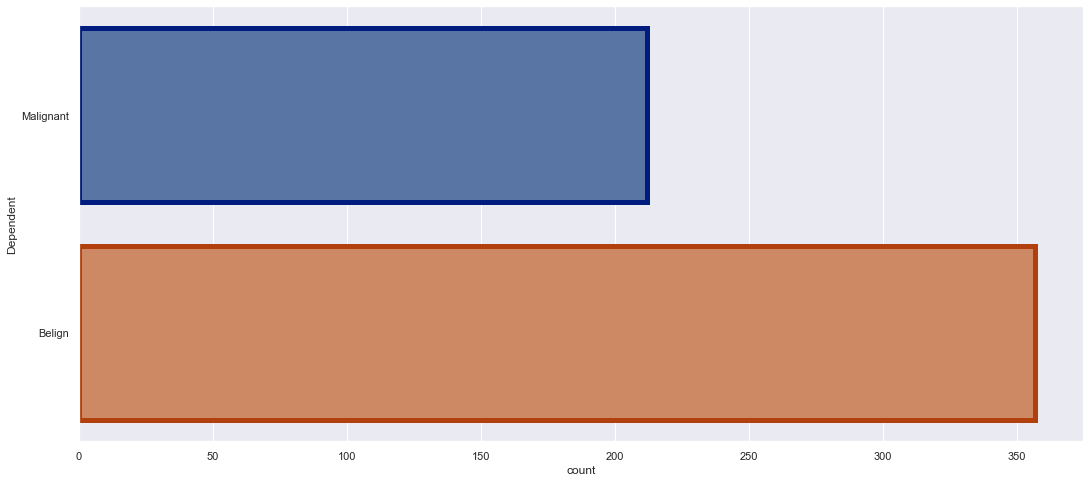

In [4]:
sns.countplot(y=data_["Dependent"],
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))


In [5]:
print(data.Dependent.value_counts())

if not data.Dependent.dtype in [np.float64,np.int64]:
    
    data["Dependent"] = [0 if i.strip() == "M" else 1 for i in data.Dependent]

elif  data.Dependent.dtype in [np.float64,np.int64]:
    data_["Dependent"] = ["Malignant" if i==0 else  "Belign"  for i in data.Dependent]

print(len(data))

print(data.head())

print("Data shape ", data.shape)



1.0    357
0.0    212
Name: Dependent, dtype: int64
569
   Dependent  mean radius  mean texture  mean perimeter  mean area  \
0        0.0        17.99         10.38          122.80     1001.0   
1        0.0        20.57         17.77          132.90     1326.0   
2        0.0        19.69         21.25          130.00     1203.0   
3        0.0        11.42         20.38           77.58      386.1   
4        0.0        20.29         14.34          135.10     1297.0   

   mean smoothness  mean compactness  mean concavity  mean concave points  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   mean symmetry  mean fractal dimension  radius error  text

In [ ]:


#%% tools for EDA for Datasets

from dataprep.eda import create_report
create_report(data)


In [ ]:
#%% exploratory data analysis
y_depent="Dependent"
x_indepent=columns_features[1:]
# fully Feature Correlation
corr_matrix = data.corr()
#print(corr_matrix)

#dependent variable correlations with independent other features
sns.heatmap(corr_matrix[[y_depent]].sort_values(by=y_depent), annot = True, fmt = ".2f",xticklabels=True, yticklabels=True)
plt.title("Correlation Between Features")
plt.show()


# for dependent subsample correlations
thresh = 0.70
filtre = np.abs(corr_matrix[y_depent]) < thresh
corr_features=np.append(corr_matrix.columns[filtre].to_numpy(),[y_depent])
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title(f"Correlation Between Features threshold= {thresh}")
plt.show()
#there some correlated features.We drop out these features because of we improve models

filtres_corr=[ corr_matrix[corr_features].corr()[i]<0.70 for i in corr_features]

for i,ser in enumerate(filtres_corr):
    ser.reset_index(drop=True,inplace=True)
    corr_matrix[corr_features].corr()[]

corr_matrix_filer=[corr_matrix<.75]

corr_pairs=corr_matrix.unstack()

sorted_pairs = corr_pairs.sort_values(kind="quicksort")

strong_pairs = sorted_pairs[(abs(sorted_pairs) <0.70)]

threscorr_pairs=strong_pairs.sort_index(level=0).unstack(level=1)



sns.heatmap(threscorr_pairs, annot = True, fmt = ".2f",xticklabels=True, yticklabels=True)
plt.title("Correlation Between Features")
plt.show()
#Correlations

?pd.reset_index()
x_vars = corr_features[:5]
y_vars = corr_features[:5]
g = sns.PairGrid(data_, hue="Dependent",x_vars=x_vars, y_vars=y_vars)
g.map_diag(sns.kdeplot, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend()


# pair plot 
sns.pairplot(data_[corr_features[6:]], diag_kind = "kde", markers = "+",hue = "Dependent")
# Kind of plot to make.
# kind{'scatter', 'kde', 'hist', 'reg'}
#Kind of plot for the diagonal subplots
# diag_kind{'auto', 'hist', 'kde', None}
plt.show()
"""
if we see kde plot .our data has positive skewness.we have to make outlier detecions to get rid of this outlier datas
"""

# %% outlier Detections 

def outliers(df,variables):
        if isinstance(variables,(np.ndarray,list)):
            variables=variables
        else:
            variables=np.expand_dims(variables,axis=0)
             
        QR_dicts={}
        for v in variables:
            q1=df[v].quantile(0.25)
            q2=df[v].quantile(0.5)
            q3=df[v].quantile(0.75)
            IQRange=q3-q2 
            low_bound=q1-(IQRange*1.5)
            high_bound=q3+(IQRange*1.5)
                   
            lower_filter=df[v]<low_bound
            upper_filter=df[v]>high_bound
            
        
            lower_outlier=df.loc[lower_filter,v]
            upper_outlier=df.loc[upper_filter,v]
            QR_dicts[v]={"low_bound":low_bound,
                         "q1":q1,
                         "q2":q2,
                         "q3":q3,
                         "high_bound":high_bound,
                         "lower_outlier":lower_outlier,
                         "upper_outlier":upper_outlier,
                         "mean":df[v].mean(),
                         "IORange":IQRange,
                         "std":df[v].std(),
                         "pearson Skewness Coef":(3*(df[v].mean()-df[v].median())/df[v].std())}
            
       
        return QR_dicts
    

    
#%% boxplot 
def show_boxplot(df,id_var,column_vars,hue="Dependent",orien="h",box=True,swarm=False,Quantil=None):
        
        plt.style.use('fivethirtyeight')
         # box plot 
        data_melted = pd.melt(df,
                              id_vars = id_var,
                              value_vars=column_vars,
                              var_name ="columns_features",
                              value_name ="Feature_values")
        
        # data_pivot= data_melted.pivot_table(
        #                               columns=data_melted.columns[1],
        #                               values=data_melted.columns[2])
           # Colors
        BG_WHITE = "#fbf9f4"
        RED_DARK = "#850e00"
        fig, ax = plt.subplots(figsize= (14, 10))
    
        
        # Some layout stuff ----------------------------------------------
        # Background color
        fig.patch.set_facecolor(BG_WHITE)
        ax.set_facecolor(BG_WHITE)
        
        if orien=="h":
            if box==True:
                ax=sns.boxplot(y = "columns_features", x = "Feature_values", hue = hue, data = data_melted,
                          whis=1.5, width=.8, palette="husl")
                # ax=sns.violinplot(y = "columns_features", x = "Feature_values", hue = hue, data = data_melted,alpha=.2,
                #               palette="flare",scale="area", width=5)
            if swarm==True:
            # Add in points to show each observation
                ax=sns.swarmplot( y = "columns_features", x = "Feature_values", data=data_melted,
                      size=3, color=".2", linewidth=1)
            plt.xticks(rotation = 0)
        
        else:
            if box==True:
                ax=sns.boxplot(x = "columns_features", y = "Feature_values", hue = hue, data = data_melted,
                             whis=1.5, width=.8, palette="husl")
                # ax=sns.violinplot(x = "columns_features", y = "Feature_values", hue = hue, data = data_melted,alpha=.2,
                #               palette="flare",
                #         scale="area", width=5 )
            if swarm==True:
                ax=sns.swarmplot( x = "columns_features", y = "Feature_values", data=data_melted,
                                    size=3, color=".2", linewidth=1)
            plt.xticks(rotation = 90)
        if Quantil!=None and len(Quantil)>1 :
            
            for i, (k,info_dict) in enumerate(QR_dicts.items()):
            
                for key,value in info_dict.items():
                        if not key in ["IORange","lower_outlier","pearson Skewness Coef","std","upper_outlier"]:
                            if orien=="v":
                                ax.scatter([i], [value], color="red",s=10, zorder=10)
                                # Add mean value label.
                                if key =="mean":
                                    ax.text(
                                            i,
                                            value,
                                            r"$\hat{\mu}_{\rm{mean}} = $" + str(round(value, 3)),
                                            fontsize=10,
                                            va="center",
                                            bbox = dict(
                                                facecolor="white",
                                                edgecolor="black",
                                                boxstyle="round",
                                                pad=0.0
                                            ),zorder=20 # to make sure the line is on top
                                            )
                            else:
                                ax.scatter([value],[i],ls="dashdot", color="red",s=10, zorder=10)
                            # Add mean value label.
                                if key =="mean":
                                    ax.text(
                                                value,
                                                i,
                                                r"$\hat{\mu}_{\rm{mean}} = $" + str(round(value, 3)),
                                                fontsize=10,
                                                va="center",
                                                rotation=90,
                                                bbox = dict(
                                                    facecolor="white",
                                                    edgecolor="black",
                                                    boxstyle="round",
                                                    ),zorder=20 # to make sure the line is on top
                                                )
                
        plt.title('Boxplots for Selected Features', fontdict={'fontweight':'bold', 'fontsize': 18})
      
            
        #ax.set_yticks([0, .5, 1])
        #ax.set_xticks(np.arange(0, 270,10))
        #ax.set_xlim(0, 5)
        ax.grid(True)
        plt.show()
        
        
        return True,data_melted
    
 #if we see boxplot, we should be stardardization,normalizations.
 #also we have outlier data point
 #our data has diferent range  .we have to make standardization-normalization to bring everyone in the same range datas
 #%% analyzing outliers
#fancyindex=[3,13,22,23] # big scale features
fancyindex=[np.arange(1,31,1)]
QR_dicts=outliers(data,columns_features[fancyindex])
_,Data_melted=show_boxplot(data,"Dependent",columns_features[fancyindex],None,"h",True,False,None)

sns.jointplot(y = "Feature_values", x = "Feature_values", hue = "columns_features", data = Data_melted ,kind="scatter")
     

#%% Local outlier Detections for Skewness Datas
y = data.Dependent
x = data.drop(["Dependent"],axis = 1)
x_columns = x.columns.tolist()
#Unsupervised Outlier Detection using Local Outlier Factor (LOF)

# which is the average local reachability density of the neighbors divided by the object's own local reachability density. A value of approximately 1 indicates that the object is comparable to its neighbors (and thus not an outlier). A value below 1 indicates a denser region (which would be an inlier), while values significantly larger than 1 indicate outliers.

# LOF(k) ~ 1 means Similar density as neighbors,

# LOF(k) < 1 means Higher density than neighbors (Inlier),

# LOF(k) > 1 means Lower density than neighbors (Outlier)
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(x)
X_score = clf.negative_outlier_factor_
#The opposite LOF of the training samples. 
# The higher, the more normal.
#  Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1)
#  , while outliers tend to have a larger LOF score

# in this data, Inliers tend to have a LOF score close to  -0.946074
#outliers tend to have a LOF score close to -3.13447
outlier_score = pd.DataFrame()
outlier_score["score"] = X_score

#set outlier threshold value
threshold = -1.6
filtre = outlier_score["score"] < threshold
outlier_index = outlier_score[filtre].index.tolist()

#we make normalizaiton.therefore we will scale the data between 0 and 1
# if score close to 1,its outlier,if score close to 0 ,its inlier
radius = (X_score.max() - X_score)/(X_score.max() - X_score.min())
outlier_score["radius"] = radius
sns.scatterplot(x.loc[:,"worst area"], x.loc[:,"mean area"], color = "g", s = 20, label = "Data Points")
# we draw a circle around the outliers
plt.scatter(x.loc[outlier_index,"worst area"], x.loc[outlier_index,"mean area"], s = 1000*radius[outlier_index], edgecolors = "red",facecolors = "none", label = "Outlier Scores")
plt.ylabel("mean area")
plt.xlabel("worst area")
plt.legend()
plt.show()

# drop outliers value
x = x.drop(outlier_index)
y = y.drop(outlier_index).values

# %% Train test split
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = test_size, random_state = 42)

# %% standardization-normalization-scalering

# we transform data to mü =0 std=1 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df = pd.DataFrame(X_train, columns = columns)
df_describe = df.describe()
df["Dependent"] = Y_train
# box plot 
data_meltedd= pd.melt(df, id_vars = "Dependent",
                      value_vars=df.columns[:-1],
                      var_name ="columns_features",
                      value_name ="Feature_values")

sns.boxplot(x= "columns_features", y= "Feature_values", hue = "Dependent", data = data_meltedd)
plt.xticks(rotation = 90)
plt.title("after standardizations for data")
plt.show()


# pair plot 
sns.pairplot(df[corr_features], diag_kind = "kde", markers = "+",hue = "Dependent")
plt.title("data pairplot its correlations threshold >0,75 ")
plt.show()


# %% Basic KNN Method

knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm,annot=True,fmt=".2f")
acc_score = accuracy_score(Y_test, y_pred)
ac_score = knn.score(X_test, Y_test)
print("Valid Accurancy Score: ",acc_score)
print("Confusion matrix: ",cm)
print("Basic KNN Acc: ",ac_score)
print("Train Accurancy Score: ",knn.score(X_train,Y_train))


# %% choose best parameters

def Model_Tune_Params(model,x_train, x_test, y_train, y_test):
    
    k_range = list(range(1,31))
    weight_options = ["uniform","distance"]
    p=np.arange(1,8,1)
    
    param_grid = dict(n_neighbors = k_range, weights = weight_options,p=p)
    
    best_model = GridSearchCV(model, param_grid, cv = 10, scoring = "roc_auc")
    best_model.fit(x_train, y_train)
    
    return best_model

knn = KNeighborsClassifier()    
grid = Model_Tune_Params(knn,X_train, X_test, Y_train, Y_test)

print("Best training score: {} with parameters: {}".format(grid.best_score_, grid.best_params_))
#%% build  Model 

knn = KNeighborsClassifier(**grid.best_params_)
knn.fit(X_train, Y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)


cm_test = confusion_matrix(Y_test, y_pred_test)
cm_train = confusion_matrix(Y_train, y_pred_train)

# plot for confusion matrix tran and Valid Data Sets
fig ,axes=plt.subplots(nrows=1, ncols=2)
fig.suptitle('confusion matrix Tran & Valid')
sns.heatmap(ax=axes[0],data=cm_train,annot=True,fmt=".2f")
axes[0].set_title("Train Data Confusion matrix")
sns.heatmap(ax=axes[1],data=cm_test,annot=True,fmt=".2f")
axes[1].set_title("Valid Data Confusion matrix")


acc_test = accuracy_score(Y_test, y_pred_test)
acc_train = accuracy_score(Y_train, y_pred_train)
print("Test Score: {}, Train Score: {}".format(acc_test, acc_train))
print("Cassificaitons report: \n ",classification_report(Y_test,y_pred_test))
print("CM Train: ", cm_train)

#%% Saving Model

# open a file, where you ant to store the data
file = open('KNN_project1/KNN_model.pkl', 'wb')
# dump information to that file
pickle.dump(Breast_KNN_moddel, file)